# Music classification and generation with spectrograms


In [85]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import torch.optim.lr_scheduler as lr_scheduler

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Train a simple CNN 

In [87]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [88]:
device = set_device()

GPU is enabled in this notebook.


In [89]:
# Create folder with training, testing and validation data.

spectrograms_dir = "/content/drive/MyDrive/Data/Data/images_original/"
folder_names = ['/content/drive/MyDrive/Data/train/', '/content/drive/MyDrive/Data/test/', '/content/drive/MyDrive/Data/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres
genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

In [103]:
# Data loading.

train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=25, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=25, shuffle=True, num_workers=0)

In [100]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self, dropout_rate=0.5):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)

    self.dropout_rate = dropout_rate
    self.dropout = nn.Dropout(p=self.dropout_rate, inplace=False)

    self.fc1 = nn.Linear(in_features=9856, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=8)
    self.batchnorm2 = nn.BatchNorm2d(num_features=16)
    self.batchnorm3 = nn.BatchNorm2d(num_features=32)
    self.batchnorm4 = nn.BatchNorm2d(num_features=64)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x, dim=1)

    return x

import torch.optim as optim #import for SGD optimiser

def train(model, device, train_loader, validation_loader, epochs,dropout_rate=0.5, weight_decay=0.0):
  criterion = nn.CrossEntropyLoss()
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=weight_decay)
  optimizer = optim.SGD(model.parameters(), lr=0.0007, momentum=0.9, weight_decay=weight_decay)

  scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

  # #early stopping
  # best_val_loss = float('inf')
  # best_val_acc = 0
  # early_stop_counter = 0

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device) # moves data to gpu
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)

        # # L1 regularization
        # l1_lambda = 0.0089
        # l1_reg = torch.tensor(0.).to(device)
        # for param in model.parameters():
        #     l1_reg += torch.norm(param, 1)
        # loss += l1_lambda * l1_reg

        # L2 regularization
        l2_lambda = 0.002
        l2_reg = torch.tensor(0.).to(device)
        for param in model.parameters():
            l2_reg += torch.norm(param, 2)
        loss += l2_lambda * l2_reg


        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss.detach().cpu().item()/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      with torch.no_grad():
        for data, target in validation_loader:
          # getting the validation set
          data, target = data.to(device), target.to(device) #moves data to gpu
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          tepochs.set_postfix(loss=loss.item())
          running_loss += loss.item()
          # get accuracy
          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  # # EARLY STOPPING
  #     # Check if the validation loss has improved
  #     if validation_loss[-1] < best_val_loss:
  #         best_val_loss = validation_loss[-1]
  #         best_val_acc = validation_acc[-1]
  #         early_stop_counter = 0
  #     else:
  #         early_stop_counter += 1

  #     # Stop training if the validation loss has not improved for 'patience' epochs
  #     if early_stop_counter >= patience:
  #         print(f"Early stopping at epoch {epoch+1}!")
  #         break
  #   tepochs.set_postfix(train_loss=train_loss[-1], val_loss=validation_loss[-1])

  #   print(f"Best validation loss: {best_val_loss}")
  #   print(f"Best validation accuracy: {best_val_acc}")

    print(train_acc) 

    scheduler.step()

    return train_loss, train_acc, validation_loss, validation_acc

  0%|          | 0/50 [00:00<?, ?epoch/s]

[0.12015018773466833, 0.246558197747184, 0.3216520650813517, 0.36795994993742176, 0.3979974968710889, 0.40550688360450565, 0.43929912390488113, 0.48685857321652065, 0.5131414267834794, 0.5531914893617021, 0.5894868585732165, 0.6132665832290363, 0.6332916145181476, 0.6733416770963705, 0.6808510638297872, 0.6958698372966208, 0.7384230287859824, 0.7622027534418022, 0.785982478097622, 0.7934918648310388, 0.799749687108886, 0.7984981226533167, 0.804755944931164, 0.8297872340425532, 0.851063829787234, 0.8423028785982478, 0.8635794743429287, 0.8723404255319149, 0.8635794743429287, 0.8785982478097623, 0.8898623279098874, 0.899874843554443, 0.9036295369211514, 0.9011264080100125, 0.9224030037546934, 0.9173967459324155, 0.9236545682102628, 0.932415519399249, 0.9311639549436797, 0.9361702127659575, 0.9299123904881101, 0.9411764705882353, 0.9436795994993742, 0.9474342928660826, 0.9461827284105131, 0.9561952440550688, 0.9486858573216521, 0.9561952440550688, 0.9561952440550688, 0.9586983729662077]


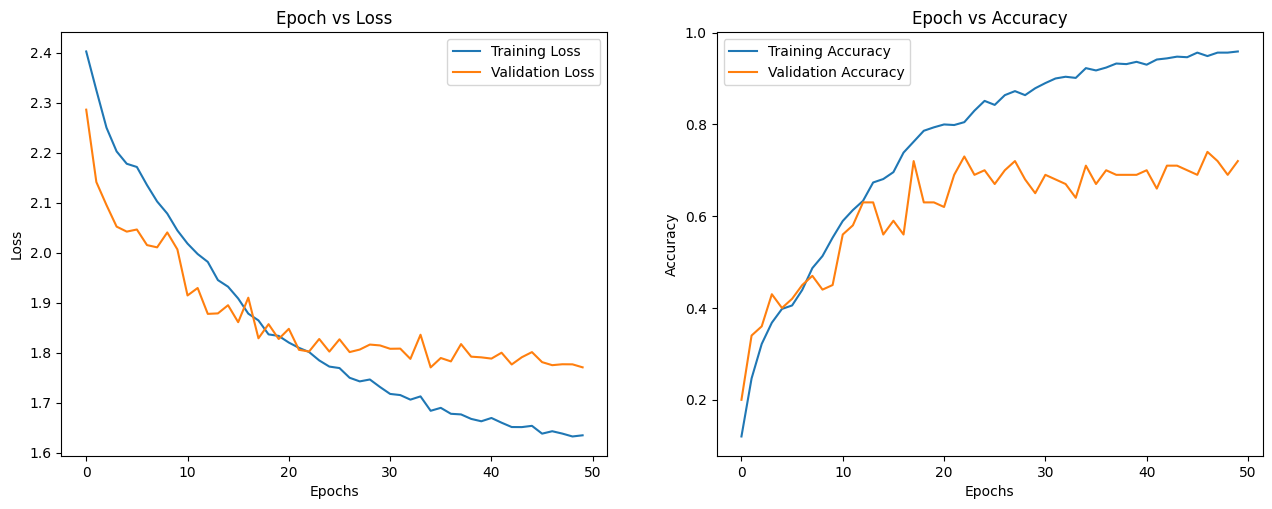

In [104]:
# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)

# Detach tensors from GPU
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [105]:
# TEST ACCURACY
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    return accuracy

# Load the test dataset
test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

# Create the data loader for testing
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=False)

# Evaluate the model on the test dataset
test_accuracy = evaluate(net, device, test_loader)
print('Test Accuracy:', test_accuracy)


Test Accuracy: 0.72


In [108]:
import torchvision.transforms.functional as TF
from PIL import Image

# Load and preprocess the image
image_path = "/content/drive/MyDrive/Data/Data/images_original/country/country00000.png"  # Update with the actual path to your spectrogram image
image = Image.open(image_path)
input_image = image.convert("RGB")
input_tensor = TF.to_tensor(input_image)
input_tensor = input_tensor.unsqueeze(0)

# Perform the classification
with torch.no_grad():
    input_tensor = input_tensor.to(device)
    output = net(input_tensor)

# Get the predicted genre
_, predicted_idx = torch.max(output, 1)
predicted_genre = train_dataset.classes[predicted_idx]
print("Predicted class:", predicted_genre)



Predicted class: country


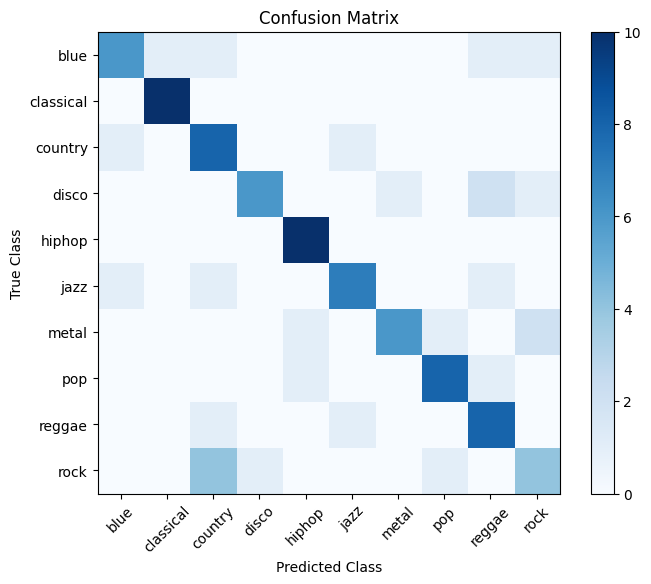

In [114]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Predict the labels for the test data
predictions = []
true_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        _, predicted = torch.max(output, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(target.cpu().numpy())

# Convert predictions and true labels to NumPy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Define class names
class_names = ['blue', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


  0%|          | 0/50 [00:00<?, ?epoch/s]

[0.967459324155194, 0.9637046307884856, 0.9624530663329162, 0.9687108886107635, 0.9649561952440551, 0.967459324155194, 0.967459324155194, 0.9724655819774718, 0.9699624530663329, 0.9712140175219024, 0.9724655819774718, 0.9699624530663329, 0.9749687108886108, 0.9724655819774718, 0.9749687108886108, 0.9762202753441802, 0.9787234042553191, 0.9749687108886108, 0.9799749687108886, 0.9762202753441802, 0.9799749687108886, 0.9787234042553191, 0.9787234042553191, 0.9799749687108886, 0.9787234042553191, 0.9799749687108886, 0.9799749687108886, 0.981226533166458, 0.9799749687108886, 0.9787234042553191, 0.9787234042553191, 0.9799749687108886, 0.9787234042553191, 0.9824780976220275, 0.981226533166458, 0.981226533166458, 0.9824780976220275, 0.9824780976220275, 0.981226533166458, 0.983729662077597, 0.9824780976220275, 0.983729662077597, 0.983729662077597, 0.983729662077597, 0.983729662077597, 0.9824780976220275, 0.9824780976220275, 0.9824780976220275, 0.983729662077597, 0.983729662077597]


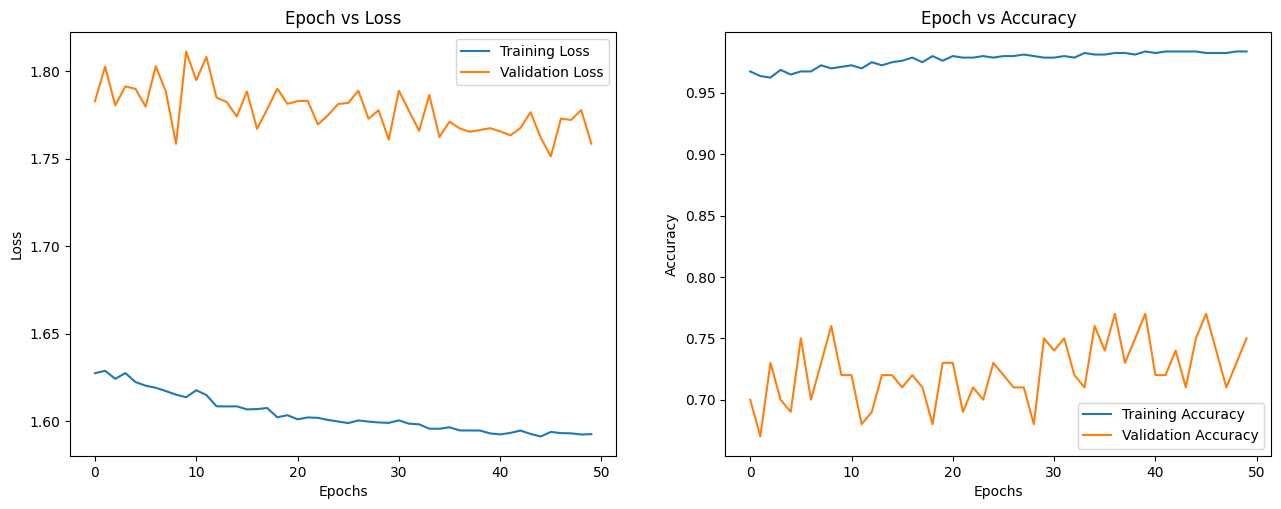

Test Accuracy: 0.73


In [107]:
# # AUGMENTATION

# import torchvision.transforms as transforms

# # Define the data transformations for augmentation
# augmentation_transform = transforms.Compose([
#     transforms.RandomCrop(size=(224, 224)),  # Randomly crop the spectrogram
#     transforms.RandomHorizontalFlip(),  # Randomly flip the spectrogram horizontally
#     transforms.ToTensor(),  # Convert the spectrogram to a tensor
#     transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the spectrogram
# ])

# # Create the augmented dataset
# augmented_dataset = datasets.ImageFolder(
#     train_dir,
#     transforms.Compose([
#         transforms.ToTensor(),
#     ]))

# # Create the data loader for augmented training data
# augmented_train_loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=25, shuffle=True)

# # Run training with augmented data
# train_loss, train_acc, validation_loss, validation_acc = train(net, device, augmented_train_loader, val_loader, 50)

# plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# # Evaluate on the test dataset
# test_accuracy = evaluate(net, device, test_loader)
# print('Test Accuracy:', test_accuracy)